In [1]:
    
import numpy as np
from numpy.linalg import norm
import networkx as nx
import cvxpy as cp



from genet.estimators import (
    GenElasticNetEstimator,
    FusedLassoEstimator,
    SmoothedLassoEstimator,
    LassoEstimator,
    NaiveEstimator,
)
from sklearn.linear_model import LinearRegression


def rng():
    return np.random.default_rng(42)

np.random.seed(42)

def incidence_path(p):
    G = nx.path_graph(p)
    return nx.incidence_matrix(G, oriented=True).T.toarray()


n, p = 150, 60
X = np.random.standard_normal((n, p))
beta_true = np.zeros(p); beta_true[10:20]=1.0; beta_true[30:45]= -0.7
y = X @ beta_true + np.random.standard_normal(n)
D = incidence_path(p)

(CVXPY) Sep 04 02:30:35 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")


In [2]:
# GEN with graph

new_X = np.random.standard_normal((n, p))
new_y = new_X @ beta_true + np.random.standard_normal(n)


solver = "cvxpy"
gen = GenElasticNetEstimator(l1=0.2, l2=0.2, D=D, solver=solver, family="normal")
gen.fit(X, y)
rmse_gen = norm(new_y - gen.predict(new_X))/np.sqrt(n)


solver = "ip"
gen_ip = GenElasticNetEstimator(l1=12, l2=0.2, D=D, solver=solver, family="normal")
gen_ip.fit(X, y)
rmse_gen_ip= norm(new_y - gen_ip.predict(new_X))/np.sqrt(n)



solver = "cgd"
gen_cgd = GenElasticNetEstimator(l1=0.1, l2=0.1, D=D, solver=solver, family="normal")
gen_cgd.fit(X, y)
rmse_gen_cgd= norm(new_y - gen_cgd.predict(new_X))/np.sqrt(n)


solver = "admm"
gen_admm = GenElasticNetEstimator(l1=12, l2=0.1, D=D, solver=solver, family="normal")
gen_admm.fit(X, y)
rmse_gen_admm= norm(new_y - gen_admm.predict(new_X))/np.sqrt(n)
                                                       

                                                      

# OLS baseline
ols = LinearRegression().fit(X, y)
rmse_ols = norm(new_y - ols.predict(new_X))/np.sqrt(n)

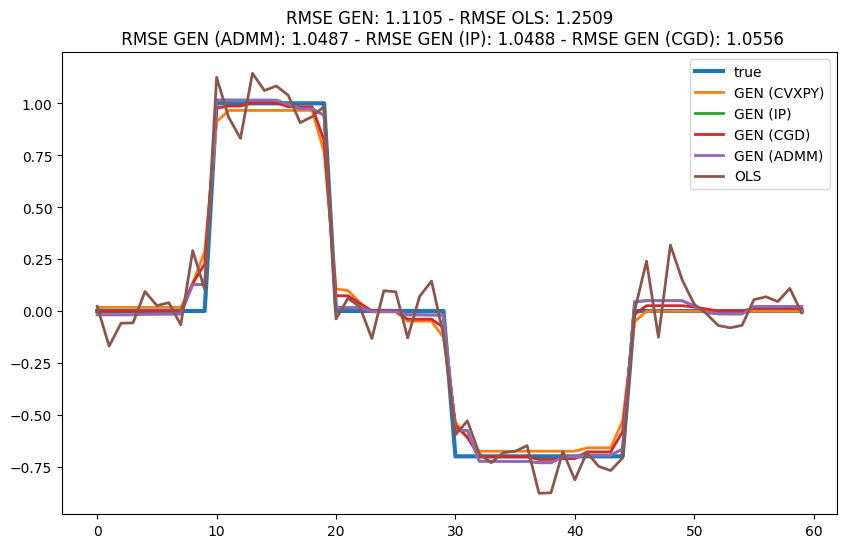

In [3]:
#### plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(beta_true, label="true", linewidth=3)
plt.plot(gen.beta, label="GEN (CVXPY)", linewidth=2)
plt.plot(gen_ip.beta, label="GEN (IP)", linewidth=2)
plt.plot(gen_cgd.beta, label="GEN (CGD)", linewidth=2)
plt.plot(gen_admm.beta, label="GEN (ADMM)", linewidth=2)
plt.plot(ols.coef_, label="OLS", linewidth=2)
plt.legend()
plt.title(f"RMSE GEN: {rmse_gen:.4f} - RMSE OLS: {rmse_ols:.4f}\n RMSE GEN (ADMM): {rmse_gen_admm:.4f} - RMSE GEN (IP): {rmse_gen_ip:.4f} - RMSE GEN (CGD): {rmse_gen_cgd:.4f}")
plt.show()

In [4]:
##### Now use the CV to tune the l1 and l2 parameters for each solver
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import logging
logging.getLogger("cvxpy").setLevel(logging.CRITICAL)

L1_GRID   = [0.005, 0.1, 0.2, 0.5, 1, 2, 5, 7, 10, 15, 17, 20, 25,  30, 50, 100, 1000]
L2_GRID = [0, 0.1, 0.2, 0.5, 1]
# GEN with fast warm-start CV
gen_admm = GenElasticNetEstimator(D=D, family="normal", solver="admm")
_, best, info = gen_admm.fit_cv(X, y, grid={"l1":L1_GRID, "l2": L2_GRID}, n_splits=5, shuffle=True, random_state=0)
print("GEN ADMM best:", best)
rmse_gen_admm= norm(new_y - gen_admm.predict(new_X))/np.sqrt(n)

gen_ip = GenElasticNetEstimator(D=D, family="normal", solver="ip")
_, best, info = gen_ip.fit_cv(X, y, grid={"l1":L1_GRID, "l2":L2_GRID}, n_splits=5, shuffle=True, random_state=0)
print("GEN IP best:", best)
rmse_gen_ip= norm(new_y - gen_ip.predict(new_X))/np.sqrt(n)


gen= GenElasticNetEstimator(D=D, family="normal", solver="cvxpy")
_, best, info = gen.fit_cv(X, y, grid={"l1":L1_GRID, "l2":L2_GRID}, n_splits=5, shuffle=True, random_state=0)
print("GEN CVX best:", best)
rmse_gen = norm(new_y - gen.predict(new_X))/np.sqrt(n)

gen_cgd= GenElasticNetEstimator(D=D, family="normal", solver="cgd")
_, best, info = gen_cgd.fit_cv(X, y, grid={"l1":L1_GRID, "l2":L2_GRID}, n_splits=5, shuffle=True, random_state=0)
print("GEN CGD best:", best)
rmse_gen_cgd= norm(new_y - gen_cgd.predict(new_X))/np.sqrt(n)


lasso_cv = make_pipeline(
    LassoCV(cv=5, n_jobs=-1, alphas = L1_GRID, random_state=0, max_iter=5000)
)
lasso_cv.fit(X, y)
rmse_lasso= norm(new_y - lasso_cv.predict(new_X))/np.sqrt(n)


lasso_cv = make_pipeline(
    LassoCV(cv=5, n_jobs=-1, alphas = L1_GRID, random_state=0, max_iter=5000)
)
lasso_cv.fit(X, y)
rmse_lasso= norm(new_y - lasso_cv.predict(new_X))/np.sqrt(n)

(CVXPY) Sep 04 02:30:37 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")
(CVXPY) Sep 04 02:30:37 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")
(CVXPY) Sep 04 02:30:37 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")
(CVXPY) Sep 04 02:30:37 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")
(CVXPY) Sep 04 02:30:37 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")
(CVXPY) Sep 04 02:30:38 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no attribute 'conetype'")
(CVXPY) Sep 04 02:30:38 PM: Encountered unexpected exception importing solver MOSEK:
AttributeError("module 'mosek' has no a

GEN ADMM best: {'l1': 20, 'l2': 0}
GEN IP best: {'l1': 20, 'l2': 0}


/opt/anaconda3/envs/genet2/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/genet2/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/genet2/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/genet2/lib/python3.10/site-packa

GEN CVX best: {'l1': 0.2, 'l2': 0}
GEN CGD best: {'l1': 0.2, 'l2': 0}


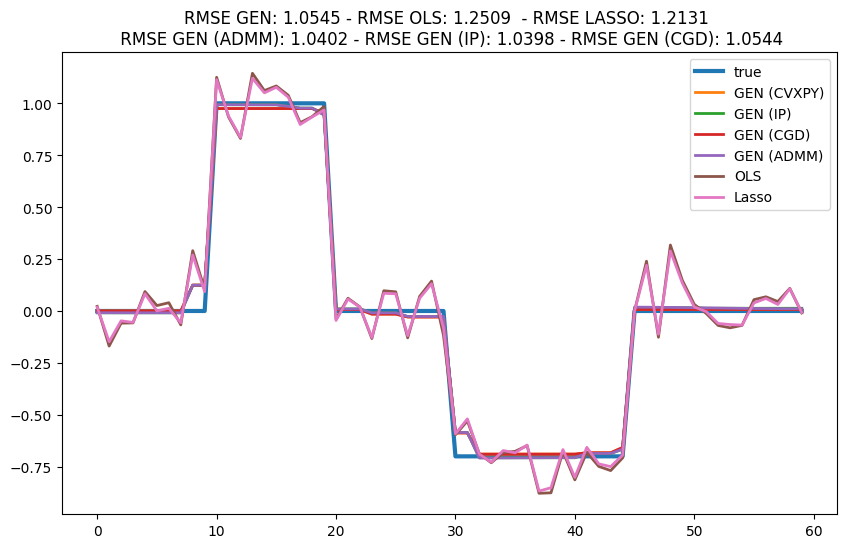

In [5]:
#### plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(beta_true, label="true", linewidth=3)
plt.plot(gen.beta, label="GEN (CVXPY)", linewidth=2)
plt.plot(gen_ip.beta, label="GEN (IP)", linewidth=2)
plt.plot(gen_cgd.beta, label="GEN (CGD)", linewidth=2)
plt.plot(gen_admm.beta, label="GEN (ADMM)", linewidth=2)
plt.plot(ols.coef_, label="OLS", linewidth=2)
plt.plot(lasso_cv.named_steps["lassocv"].coef_, label="Lasso", linewidth=2)
plt.legend()
plt.title(f"RMSE GEN: {rmse_gen:.4f} - RMSE OLS: {rmse_ols:.4f}  - RMSE LASSO: {rmse_lasso:.4f} \n RMSE GEN (ADMM): {rmse_gen_admm:.4f} - RMSE GEN (IP): {rmse_gen_ip:.4f} - RMSE GEN (CGD): {rmse_gen_cgd:.4f}")
plt.show()